In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
import os

os.getcwd()

'/home/kangi/robust-fl/notebooks'

In [7]:
no_straggle = pd.read_csv('../src/output/MNIST/MLP/RFA/whole/no_straggle/report.csv')
# yes_straggle = pd.read_csv('../src/output/MNIST/MLP/RFA/whole/5_straggle/report.csv')

<Axes: >

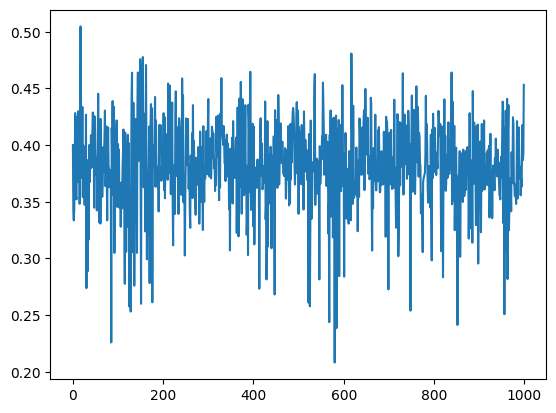

In [8]:
no_straggle.accuracy_score.plot()

<Axes: >

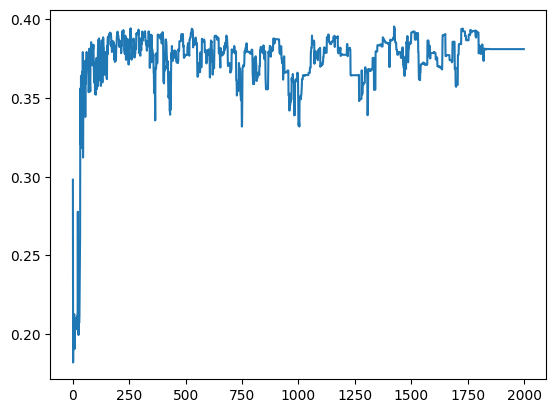

In [ ]:
yes_straggle.accuracy_score.plot()